<a href="https://colab.research.google.com/github/DreamTeamInc/Core-DS/blob/issues%2F1/Core_EDA_Andrew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
from google.colab import drive
drive.mount('/content/drive')

# Path to 'sample_core_analysis_data_example' folder with folder name
path_to_data = 'drive/My Drive/ sample_core_analysis_data_example'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Initializing packages

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from skimage import exposure
from skimage import io

# Exploratory Data Analysis

In [67]:
data = pd.read_csv(path_to_data + '/data.csv')
data

,task_id,photo_id,photo_type,segment_num,segment_type,segment_value
0,c6a24494_7931_4ca9_a148_f1fd9785b607,1012473,УФ,0,Свечение,Насыщенное
1,c6a24494_7931_4ca9_a148_f1fd9785b607,1012473,УФ,1,Свечение,Отсутствует
2,cfb8e7b2_7c98_4bd4_897d_0e5e95801bc9,1016625,УФ,0,Свечение,Карбонатное
3,a9d8f546_9046_46ce_ba17_abda344a0980,1013361,УФ,0,Свечение,Карбонатное
4,eb09a8aa_6c77_41de_8489_f5a390c789e8,1016727,УФ,0,Свечение,Карбонатное
...,...,...,...,...,...,...
14910,de63ac27_e98e_459a_9672_b07415228a50,1009408,ДС,6,Разрушенность,Разлом
14911,de63ac27_e98e_459a_9672_b07415228a50,1009408,ДС,7,Разрушенность,Разлом
14912,de63ac27_e98e_459a_9672_b07415228a50,1009408,ДС,8,Разрушенность,Разлом
14913,de63ac27_e98e_459a_9672_b07415228a50,1009408,ДС,9,Разрушенность,Разлом


In [68]:
print('Классификация сегментов керна:',pd.unique(data['segment_value'].values))

Классификация сегментов керна: ['Насыщенное' 'Отсутствует' 'Карбонатное' 'Разлом' 'Аргиллит'
 'Переслаивание пород' 'Алевролит глинистый' 'Песчаник' 'Проба'
 'Глинисто-кремнистая порода' 'Песчаник глинистый' 'Уголь'
 'Аргиллит углистый' 'Алевролит' 'Карбонатная порода' 'Известняк'
 'Глина аргиллитоподобная']


In [69]:
print('Классификация сегментов', pd.unique(data['segment_type'].values))

Классификация сегментов ['Свечение' 'Разрушенность' 'Порода']


In [70]:
print('Свечение - ', pd.unique(data[data['segment_type'] == 'Свечение']['segment_value'].values))
print('Разрушенность - ', pd.unique(data[data['segment_type'] == 'Разрушенность']['segment_value'].values))
print('Порода - ', pd.unique(data[data['segment_type'] == 'Порода']['segment_value'].values))

Свечение -  ['Насыщенное' 'Отсутствует' 'Карбонатное']
Разрушенность -  ['Разлом' 'Проба']
Порода -  ['Аргиллит' 'Переслаивание пород' 'Алевролит глинистый' 'Песчаник'
 'Глинисто-кремнистая порода' 'Песчаник глинистый' 'Уголь'
 'Аргиллит углистый' 'Алевролит' 'Карбонатная порода' 'Известняк'
 'Глина аргиллитоподобная']


# Functions

In [71]:
def get_photo(data,i):
  return io.imread(path_to_data + '/photos/{}.jpeg'.format(data['photo_id'][i]))

def get_mask(data,i):
  return np.load(path_to_data + '/matrixes/matrix_{}__{}.npz'.format(data['photo_id'][i], data['task_id'][i]))['data']

def get_json(data, i):
    datastore = ''
    with open(path_to_data + '/extra/extra_{}__{}.json'.format(data['photo_id'][i],
                                                               data['task_id'][i]), 'r', encoding="utf8") as f:
        datastore = json.load(f)
    return datastore

def show_image(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image)
    ax.axis('off')
    return fig, ax

def show_all(data, i):
    print(data.iloc[i])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 14))
    ax1.imshow(get_photo(data, i))
    ax1.axis('off')

    cmap = plt.get_cmap('tab20b', np.max(get_mask(data, i)) + 1)
    mask = ax2.imshow(get_mask(data, i), cmap=cmap,
                      vmin=-0.5, vmax=np.max(get_mask(data, i))+0.5)
    ax2.axis('off')
    fig.colorbar(mask, ticks=np.arange(0, np.max(get_mask(data, i))+1))
    return fig, (ax1, ax2)

def show_photo_seies(data, column, value):
    fig, ax_ar = plt.subplots(1, 10, figsize=(14, 14))
    filt_data = data[data[column] == value]
    i = np.random.randint(0, filt_data.shape[0])
    for ax in ax_ar:
        filt_by_photo = filt_data[filt_data['photo_id'] == filt_data['photo_id'].iloc[i]]
        segments = filt_by_photo['segment_num'].values
        photo = get_photo(data, filt_by_photo.index.values[0])
        mask = get_mask(data, filt_by_photo.index.values[0])
        for value in segments:
            mask = np.ma.masked_where(mask == value, mask)
        
        ax.imshow(photo)
        ax.imshow(mask)
        ax.axis('off')
        filt_data.drop(filt_by_photo.index.values, axis=0, inplace=True)
        i = np.random.randint(0, filt_data.shape[0])
    
    return fig, ax_ar

task_id          dbc6e14c_1db2_4314_91b4_89b0bb65c6d1
photo_id                                      1008090
photo_type                                         ДС
segment_num                                         0
segment_type                            Разрушенность
segment_value                                  Разлом
Name: 1400, dtype: object


(<Figure size 1008x1008 with 3 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7f0d9d4d9d68>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f0d9cc5d160>))

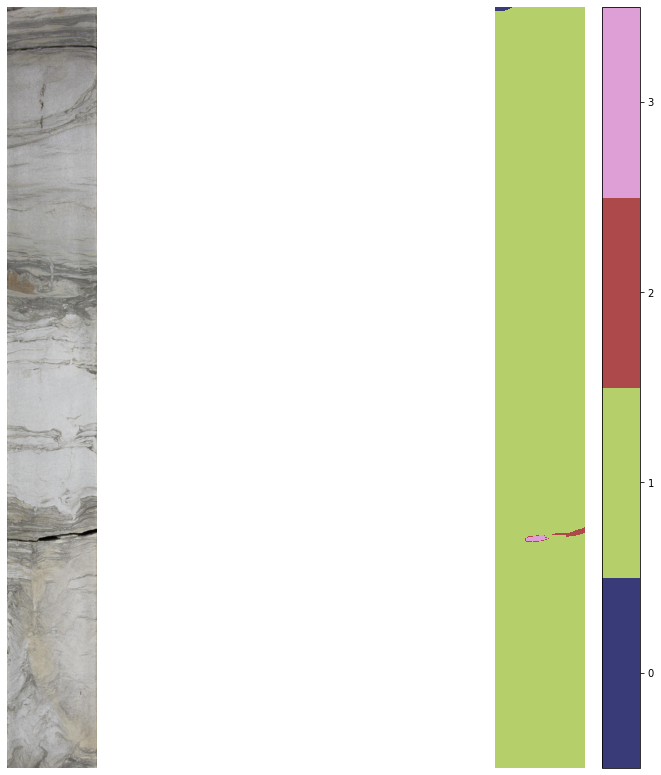

In [72]:
show_all(data, 1400)

(<Figure size 1008x1008 with 10 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d9bdf67b8>,
       dtype=object))

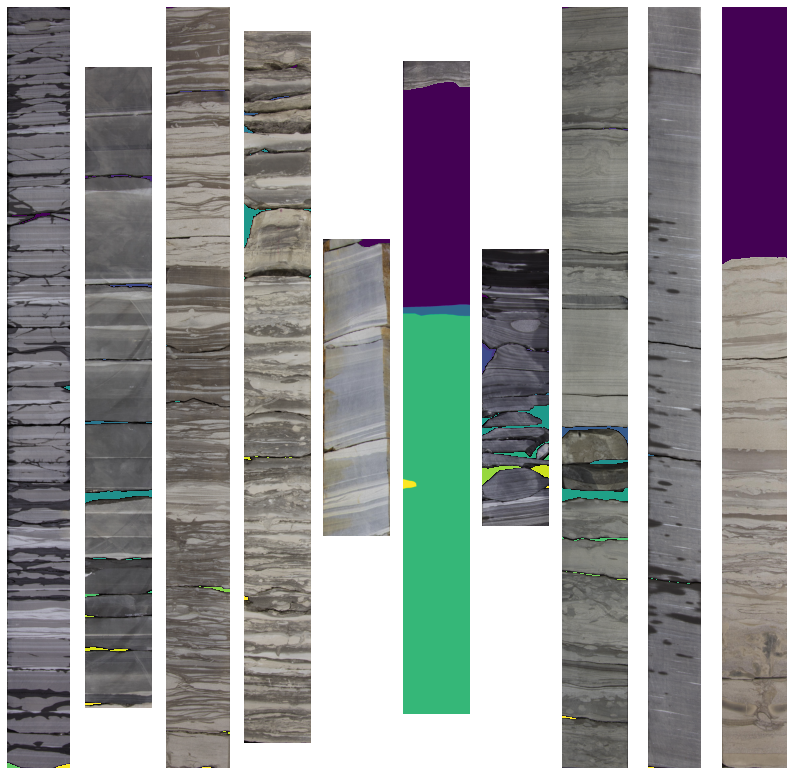

In [74]:
 show_photo_seies(data, 'segment_value', 'Переслаивание пород')